# Final Project 

In [52]:
# Libraries 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import gensim
from gensim.models import LdaModel
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import CoherenceModel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis.lda_model
import warnings
# Ignore FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from textblob import TextBlob

In [53]:
# Load the dataset
data = pd.read_csv("Donald Trumps Facebook Statuses.csv")

# information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4540 entries, 0 to 4539
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   status_id         4539 non-null   object 
 1   status_message    3794 non-null   object 
 2   link_name         2715 non-null   object 
 3   status_type       4160 non-null   object 
 4   status_link       2983 non-null   object 
 5   status_published  4160 non-null   object 
 6   num_reactions     4160 non-null   float64
 7   num_comments      4160 non-null   float64
 8   num_shares        4160 non-null   float64
 9   num_likes         4160 non-null   float64
 10  num_loves         4160 non-null   float64
 11  num_wows          4160 non-null   float64
 12  num_hahas         4160 non-null   float64
 13  num_sads          4160 non-null   float64
 14  num_angrys        4159 non-null   float64
dtypes: float64(9), object(6)
memory usage: 532.2+ KB


In [54]:
# showing the first few rows of the dataset
data.head()

,status_id,status_message,link_name,status_type,status_link,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,153080620724_10157915294545725,Beautiful evening in Wisconsin- THANK YOU for ...,Timeline Photos,photo,https://www.facebook.com/DonaldTrump/photos/a....,10/17/2016 20:56:51,6813.0,543.0,359.0,6178.0,572.0,39.0,17.0,0.0,7.0
1,153080620724_10157914483265725,The State Department's quid pro quo scheme pro...,NaN,video,https://www.facebook.com/DonaldTrump/videos/10...,10/17/2016 18:00:41,33768.0,3644.0,17653.0,26649.0,487.0,1155.0,75.0,191.0,5211.0
2,153080620724_10157913199155725,Crooked Hillary's State Department colluded wi...,NaN,video,https://www.facebook.com/DonaldTrump/videos/10...,10/17/2016 15:34:46,85627.0,8810.0,32594.0,73519.0,2943.0,1020.0,330.0,263.0,7552.0
3,153080620724_10157912962325725,"JournoCash: Media gives $382,000 to Clinton, $...","JournoCash: Media gives $382,000 to Clinton, $...",link,http://www.washingtonexaminer.com/journocash-m...,10/17/2016 14:17:24,22696.0,3665.0,5082.0,14029.0,122.0,2091.0,241.0,286.0,5927.0
4,153080620724_10157912187170725,"Exclusive: ""O'Keefe Video Sting Exposes 'Bird-...",O'Keefe Reveals 'Bird-Dogging' to Incite Viole...,link,http://www.breitbart.com/big-government/2016/1...,10/17/2016 12:03:19,40729.0,4905.0,17087.0,26472.0,178.0,2588.0,154.0,417.0,10922.0


## <span style="color:orange;">QUESTION 1: Use charts (histogram/bar graph) to display the distribution of types of statuses (photo, video, link, and status).</span>

In [55]:
data['status_type'].value_counts() # counting the value of each status type

status_type
photo                    1539
status                   1177
link                      763
video                     679
http://bit.ly/2duCRlw       1
event                       1
Name: count, dtype: int64

In [56]:
# Filtering out rows from the 'data' DataFrame where the 'status_type' column values are not 'http://bit.ly/2duCRlw' or 'event'
data = data[~data['status_type'].isin(['http://bit.ly/2duCRlw', 'event'])]

# Counting the occurrences of each unique value in the 'status_type' column after filtering
data['status_type'].value_counts()


status_type
photo     1539
status    1177
link       763
video      679
Name: count, dtype: int64

In [57]:
# Drop the 'status_id' column from the DataFrame 'data' since it's not needed for analysis.
data = data.drop(columns=['status_id'])
# Drop rows with missing values in the 'num_likes' column from the DataFrame 'data'.
# inplace=True modifies the DataFrame in place, without creating a new DataFrame.
data.dropna(subset=['num_likes'], inplace=True)
# Calculate the count of missing values in each column of the DataFrame 'data'.
nan_count = data.isna().sum()
# Return the count of missing values in each column as a Series named 'nan_count'.
nan_count

status_message       366
link_name           1445
status_type            0
status_link         1177
status_published       0
num_reactions          0
num_comments           0
num_shares             0
num_likes              0
num_loves              0
num_wows               0
num_hahas              0
num_sads               0
num_angrys             0
dtype: int64

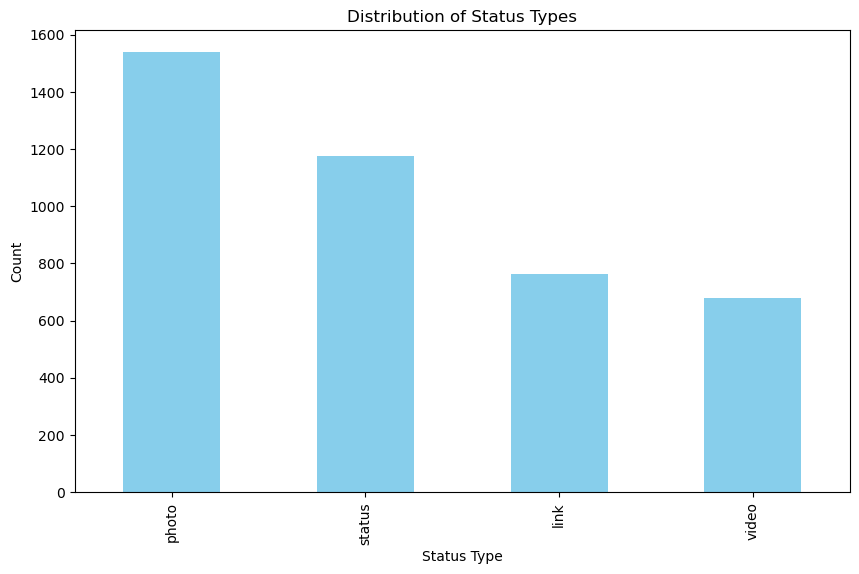

In [58]:
# Distribution of types of statuses (photo, video, link, and status)
status_types = data['status_type'].value_counts()
plt.figure(figsize=(10, 6))
status_types.plot(kind='bar', color='skyblue')
plt.title('Distribution of Status Types')
plt.xlabel('Status Type')
plt.ylabel('Count')
plt.show()

## <span style="color:orange;">QUESTION 2: Plot a chart showing the progression of likes, loves, and sads, and angrys over time.</span>

In [59]:
# Importing the seasonal_decompose function from the statsmodels library to perform seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
# Converting the 'status_published' column in the DataFrame 'data' to datetime format using pd.to_datetime() function
data['status_published'] = pd.to_datetime(data['status_published'])

# Setting the 'status_published' column as the index of the DataFrame 'data' to enable time series analysis
data.set_index('status_published', inplace=True)

In [60]:
# Resample the 'data' DataFrame to a weekly frequency using the sum aggregation function.
weekly_data = data.resample('W').sum()
# List of reactions to be analyzed, including the number of likes, loves, sads, and angry reactions.
reactions = ['num_likes', 'num_loves', 'num_sads', 'num_angrys']

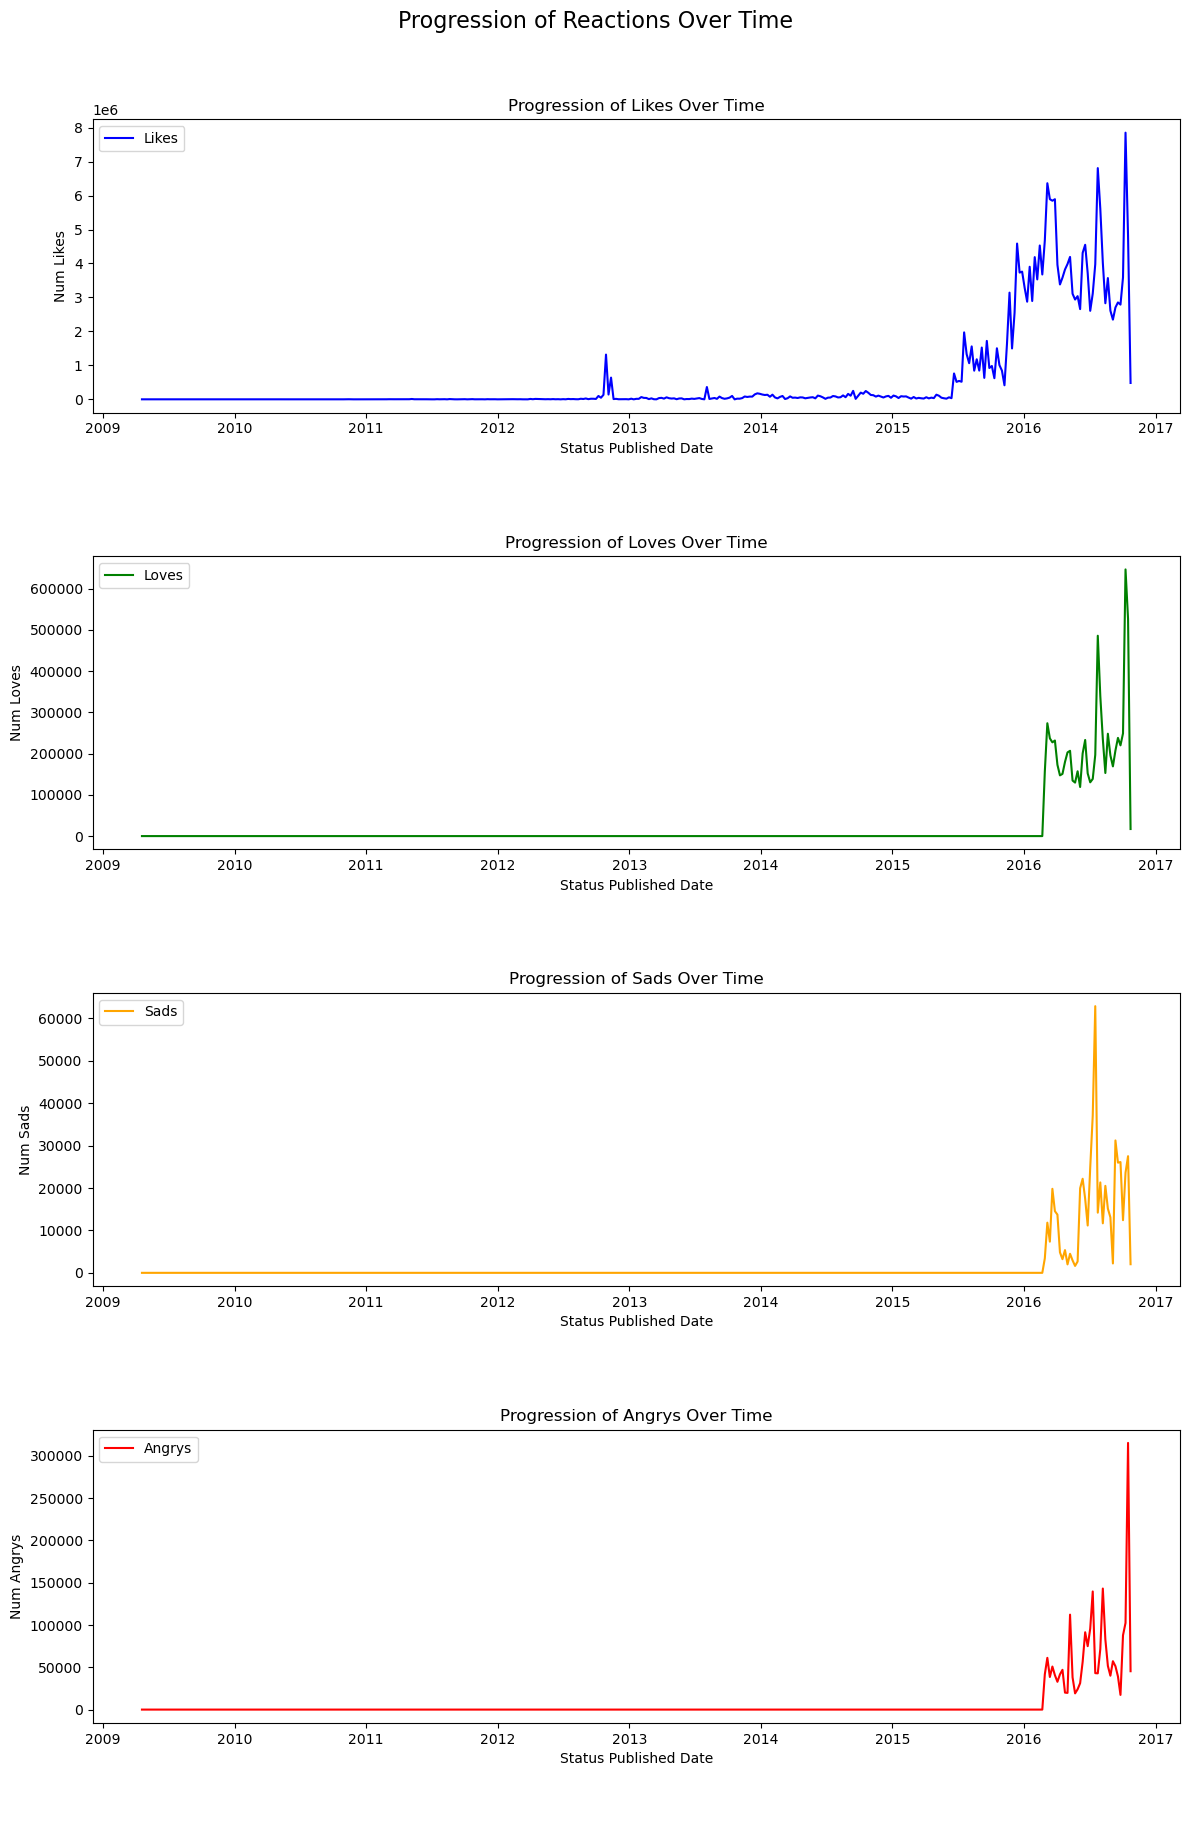

In [61]:
# Create subplots for each reaction
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 18), sharex=False)

# Plotting the progression of likes, loves, sads, and angrys over time
axes[0].plot(weekly_data.index, weekly_data['num_likes'], label='Likes', color='blue')
axes[1].plot(weekly_data.index, weekly_data['num_loves'], label='Loves', color='green')
axes[2].plot(weekly_data.index, weekly_data['num_sads'], label='Sads', color='orange')
axes[3].plot(weekly_data.index, weekly_data['num_angrys'], label='Angrys', color='red')

# Adjust subplot settings
for i, (ax, reaction) in enumerate(zip(axes, ['Likes', 'Loves', 'Sads', 'Angrys'])):
    ax.set_ylabel(f'Num {reaction}') # Set y-axis label for each subplot
    ax.legend() # Display legend for each subplot
    ax.set_title(f'Progression of {reaction} Over Time')  # Set title for each subplot
    ax.set_xlabel('Status Published Date\n\n\n\n')  # Set x-axis label for each subplot

plt.suptitle('Progression of Reactions Over Time', y=1.02, fontsize=16)  # Set main title for the entire figure
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the plot

## <span style="color:orange;">QUESTION 3: What are the top reactions expressed by Trump’s Facebook audience?</span>

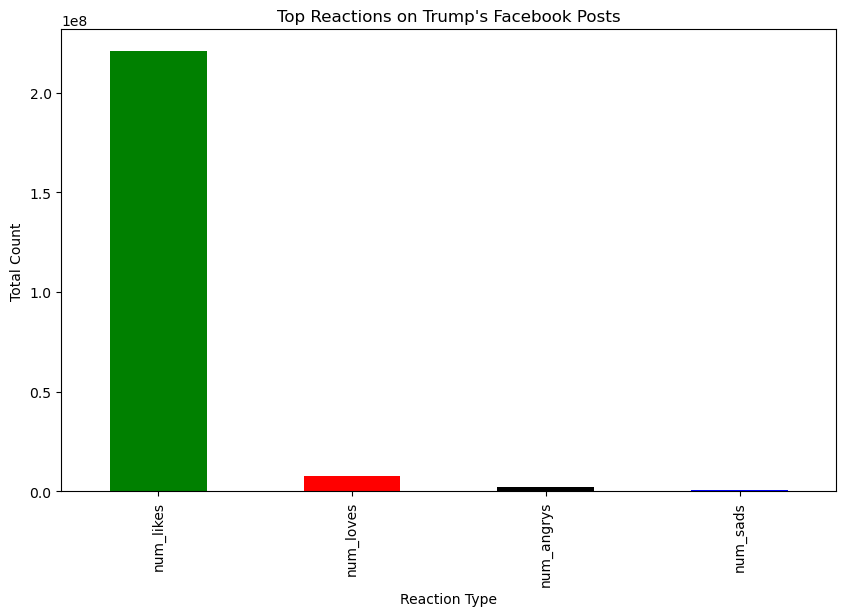

Top Reactions:
num_likes     220669482.0
num_loves       7706060.0
num_angrys      2269144.0
num_sads         540292.0
dtype: float64


In [62]:
# Sum the counts for each reaction type
total_reactions = data[['num_likes', 'num_loves', 'num_sads', 'num_angrys']].sum()

# Sort reactions in descending order
top_reactions = total_reactions.sort_values(ascending=False)

# Plot the top reactions
plt.figure(figsize=(10, 6))
top_reactions.plot(kind='bar', color=['green', 'red', 'black', 'blue'])
plt.title('Top Reactions on Trump\'s Facebook Posts')  # Set title for the plot
plt.xlabel('Reaction Type')  # Label the x-axis
plt.ylabel('Total Count')  # Label the y-axis
plt.show()  # Display the plot

# Display the top reactions and their counts
print("Top Reactions:")
print(top_reactions)


# <span style="color:purple;">QUESTION 4: Analyze the content in the status_message to find the top 10 topics (Topic modeling LDA can be used). Can you tell if fans are particularly happy or upset about the topics?</span>

## Cleaning and prerpcessing

In [63]:
# Reset the index of the DataFrame while dropping the existing index
data = data.reset_index(drop=True)

def clean_text(text):
    """
    Function to clean text data by removing URLs, special characters, numbers,
    extra whitespaces, and converting text to lowercase.
    
    Args:
    text (str): Input text to be cleaned.
    
    Returns:
    str: Cleaned text.
    """
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text)
    # Convert to lowercase
    text = text.lower()
    return text

def preprocess_and_tokenize(txt):
    """
    Function to preprocess and tokenize text data by cleaning, removing stopwords,
    filtering by word length, lowercase conversion, and lemmatization.
    
    Args:
    txt (str): Input text to be preprocessed and tokenized.
    
    Returns:
    list: List of final tokens after preprocessing and tokenization.
    """
    # Clean text
    txt = clean_text(txt)
    
    # Stop word removal and length filtering
    stop_words = set(stopwords.words('english'))
    filtered_text = [word for word in word_tokenize(txt) if word.isalnum() and len(word) > 3 and word.lower() not in stop_words]
    
    # Lowercase change and lemmatization using WordNet Lemmatizer
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_text]
    txt = ' '.join(lemmatized_words).lower()
    
    # Tokenize, remove stopwords, and lemmatize again
    words = word_tokenize(txt)
    final_tokens = [lemmatizer.lemmatize(word) for word in words if word.isalnum() and word.lower() not in stop_words]

    return final_tokens

In [64]:
# Tokenize and preprocess the text
tokens = data['status_message'].dropna().apply(preprocess_and_tokenize)

## Finding the optimal number for topics with CoherenceModel

In [65]:
# Creating a Dictionary object from a list of tokens 
dictionary = gensim.corpora.Dictionary(tokens)

# Filtering the dictionary to remove extremely rare and common words
# no_below: Minimum number of documents a word must appear in to be kept
# no_above: Maximum proportion of documents a word can appear in to be kept
# keep_n: Maximum number of words to keep, ordered by frequency across the corpus
dictionary.filter_extremes(no_below=5, no_above=0.1, keep_n=100000)

# Converting the tokens into bag-of-words format
# Each document represented as a list of (word_id, word_frequency) tuples
bag_word = [dictionary.doc2bow(token) for token in tokens]


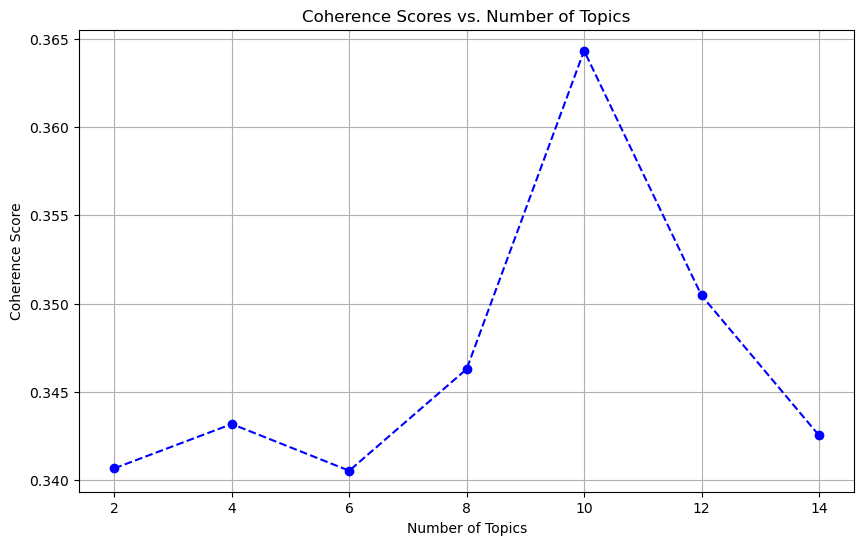

In [15]:
# Initializing a list to store coherence scores
coherence_scores = []

# Iterating over different numbers of topics
for num_topics in range(2, 16, 2): 
    # Building the LDA model with specified parameters
    lda_model = gensim.models.LdaMulticore(corpus=bag_word, num_topics=num_topics, id2word=dictionary, passes=10, workers=2)
    # Calculating coherence score for the LDA model
    coherence_model = CoherenceModel(model=lda_model, texts=tokens, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    # Appending the coherence score to the list
    coherence_scores.append(coherence_score)

# Plotting the elbow curve to visualize coherence scores for different numbers of topics
plt.figure(figsize=(10, 6))
plt.plot(range(2, 16, 2), coherence_scores, marker='o', linestyle='--', color='b')  # Plotting coherence scores
plt.xlabel("Number of Topics") # Labeling x-axis
plt.ylabel("Coherence Score")  # Labeling y-axis
plt.title("Coherence Scores vs. Number of Topics")  # Setting the title of the plot
plt.xticks(range(2, 16, 2)) # Setting x-axis ticks
plt.grid(True) # Displaying grid lines
plt.show() # Displaying the plot

## <span style="color:brown;">Method 1: Retrieve TOP 10 topics with LdaMulticore.</span>

In [66]:
# Creating an LDA model instance using the LdaMulticore class for parallel processing
# Parameters:
#   - corpus: The bag of words representation of the corpus, typically in the form of a document-term matrix
#   - num_topics: The number of topics to be extracted from the corpus
#   - id2word: Mapping from word IDs to words, typically generated using a dictionary
#   - passes: The number of passes through the corpus during training
#   - workers: The number of CPU cores to use for parallel processing (2 cores in this case)
lda_ml = gensim.models.LdaMulticore(corpus=bag_word, num_topics=10, id2word = dictionary, passes = 50, workers=2)

In [67]:
# Get the topics and their top keywords using the print_topics method of the LDA model (lda_ml)
topics = lda_ml.print_topics(num_words=10)

# Display the topics and their top keywords
for topic in topics:
    # Extract the topic index and its associated keywords
    topic_index, topic_keywords = topic
    # Parse the keywords from the formatted string and join them into a comma-separated list
    keyword_list = ', '.join([word.split('*')[1].strip() for word in topic_keywords.split('+')])
    # Print the topic index and its associated keywords
    print(f'Topic {topic_index}: {keyword_list}')

Topic 0: "vote", "poll", "safe", "iowa", "together", "support", "morning", "everyone", "carolina", "caucus"
Topic 1: "support", "love", "makeamericagreatagain", "movement", "vote", "campaign", "let", "going", "amazing", "time"
Topic 2: "job", "american", "trade", "deal", "plan", "million", "going", "country", "president", "obama"
Topic 3: "like", "cruz", "people", "think", "take", "last", "would", "country", "israel", "veteran"
Topic 4: "golf", "university", "international", "judge", "justice", "court", "course", "president", "hotel", "obama"
Topic 5: "american", "people", "country", "clinton", "want", "going", "every", "special", "time", "government"
Topic 6: "debate", "donald", "wonderful", "look", "melania", "national", "forward", "happy", "tonight", "people"
Topic 7: "tonight", "apprentice", "watch", "show", "ivanka", "live", "thought", "night", "celebrity", "really"
Topic 8: "clinton", "crooked", "president", "state", "obama", "isi", "country", "radical", "foundation", "would"
Top

## <span style="color:brown;">Method 2: Retrieve TOP 10 topics with LatentDirichletAllocation.</span>

In [68]:
# Combine tokens into a single string for analysis
text_for_analysis = [' '.join(token_list) for token_list in tokens]

# Vectorize the text using CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(text_for_analysis)

# Apply Latent Dirichlet Allocation (LDA) for topic modeling
num_topics = 10
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)

# Display the top words for each topic
feature_names = vectorizer.get_feature_names_out()
topics = {}
for topic_idx, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[:-10 - 1:-1] # Extract the indices of the top 10 words for each topic
    top_words = [feature_names[i] for i in top_words_idx]  # Get the actual words using the indices
    topics[f'Topic {topic_idx + 1}'] = top_words  # Store the top words for the current topic

# Print the top words for each topic
for topic, top_words in topics.items():
    print(f"{topic}: {', '.join(top_words)}")  # Display the top words for each topic

Topic 1: trump, makeamericagreatagain, golf, watch, great, ivanka, donald, apprentice, tonight, iowa
Topic 2: hillary, clinton, crooked, obama, president, would, bernie, question, watch, debate
Topic 3: clinton, hillary, president, obama, crooked, state, medium, justice, judge, court
Topic 4: miss, tonight, live, night, great, show, apprentice, thought, enforcement, prayer
Topic 5: america, great, make, thank, family, time, safe, state, together, honor
Topic 6: special, self, interest, funding, trumpadvice, father, marco, wonderful, rubio, lobbyist
Topic 7: trump, donald, republican, great, campaign, president, state, party, today, israel
Topic 8: american, clinton, country, people, hillary, job, going, america, want, state
Topic 9: great, america, thank, make, support, vote, together, safe, trump, going
Topic 10: people, trump, republican, campaign, life, best, candidate, vote, american, million


# Visualizing LDA Top 10 Topics results with pyLDAvi

In [69]:
# Enable the visualization capabilities of pyLDAvis in the Jupyter Notebook environment.
pyLDAvis.enable_notebook()

# Prepare the visualization of the LDA (Latent Dirichlet Allocation) model for display.
# 'lda' is the trained LDA model object.
# 'X' is the document-term matrix representing the corpus.
# 'vectorizer' is the vectorizer used to convert text data into a numerical format.
my_lda_vis = pyLDAvis.lda_model.prepare(lda, X, vectorizer)

# Display the prepared visualization of the LDA model.
my_lda_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.108920 -0.145165       1        1  31.777712
8     -0.251468 -0.147281       2        1  14.580440
0     -0.109172  0.163026       3        1  10.099552
6     -0.004316  0.056125       4        1   9.193186
2      0.170272 -0.062120       5        1   7.975502
9      0.074664 -0.001213       6        1   7.284410
1      0.129880 -0.041226       7        1   6.451441
4     -0.157025 -0.066402       8        1   6.002545
3     -0.029415  0.145413       9        1   4.221696
5      0.067660  0.098843      10        1   2.413516, topic_info=         Term         Freq        Total Category  logprob  loglift
223   america   935.000000   935.000000  Default  30.0000  30.0000
6513    trump  1020.000000  1020.000000  Default  29.0000  29.0000
6308    thank   710.000000   710.000000  Default  28.0000  28.0000
2748    great  1029.000000  1029.000000  Default  27.0000  27.0000
3797     make   716.000000   716.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
6996    woman     6.742943    81.662088  Topic10  -5.4603   1.2300
7009     work     7.002516   125.694764  Topic10  -5.4226   0.8365
2848    happy     5.839935    51.407265  Topic10  -5.6041   1.5490
4160     need     6.005332   183.518164  Topic10  -5.5762   0.3044
263   another     5.485589   116.770356  Topic10  -5.6667   0.6660

[706 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
15        6  0.849388     abortion
28        5  0.169260      academy
28        8  0.677040      academy
114       4  0.935209  advertising
139       1  0.985982      african
...     ...       ...          ...
7052      5  0.028009         york
7052      6  0.014004         york
7052      7  0.063019         york
7052      8  0.049015         york
7052      9  0.049015         york

[1742 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 9, 1, 7, 3, 10, 2, 5, 4, 6])

## Saving the pyLDAvis in html file

In [70]:
# Saving the generated pyLDAvis visualization as an HTML file named 'TOP_10_topics.html'.
# 'my_lda_vis' is assumed to be the visualization object generated by pyLDAvis.
pyLDAvis.save_html(my_lda_vis, 'TOP_10_topics.html')

# Can we tell if fans are particularly happy or upset about the topics?

In [71]:
# creating a function to analyze sentiment using TextBlob
def analyze_sentiment(text):
    # Create a TextBlob object
    blob = TextBlob(text)
    # Get the sentiment polarity
    sentiment = blob.sentiment.polarity
    return sentiment

topic_sentiments = {}

# looping through each topic and analyze sentiment of each
for topic, text in topics.items():
    # creating a single string with joining the list of text tokens
    text_for_sentiment = ' '.join(text)
    # Analyzing the sentiment with TextBlob
    sentiment_score = analyze_sentiment(text_for_sentiment)
    # Storing the sentiment score for the topic
    topic_sentiments[topic] = sentiment_score

# Printing the sentiment scores for each topics
for topic, sentiment_score in topic_sentiments.items():
    print(f"Topic: {topic} | Sentiment Score: {round (sentiment_score, 2)}")


Topic: Topic 1 | Sentiment Score: 0.8
Topic: Topic 2 | Sentiment Score: 0.0
Topic: Topic 3 | Sentiment Score: 0.0
Topic: Topic 4 | Sentiment Score: 0.47
Topic: Topic 5 | Sentiment Score: 0.65
Topic: Topic 6 | Sentiment Score: 0.68
Topic: Topic 7 | Sentiment Score: 0.8
Topic: Topic 8 | Sentiment Score: 0.0
Topic: Topic 9 | Sentiment Score: 0.65
Topic: Topic 10 | Sentiment Score: 0.5


#### Positive sentiment: Score > 0
#### Neutral sentiment: Score = 0
#### Negative sentiment: Score < 0

#### Result is that fans are particularly happy about the top 10 topics. In the following I will explain each of sentiment analysis => 

    Topic 1: Sentiment Score: 0.8 (Positive)
    Topic 2: Sentiment Score: 0.0 (Neutral)
    Topic 3: Sentiment Score: 0.0 (Neutral)
    Topic 4: Sentiment Score: 0.468 (Neutral to slightly positive)
    Topic 5: Sentiment Score: 0.65 (Positive)
    Topic 6: Sentiment Score: 0.679 (Positive)
    Topic 7: Sentiment Score: 0.8 (Positive)
    Topic 8: Sentiment Score: 0.0 (Neutral)
    Topic 9: Sentiment Score: 0.65 (Positive)
    Topic 10: Sentiment Score: 0.5 (Neutral to positive)

## <span style="color:orange;">QUESTION 5: What are the themes (topics or top words) that generated a lot of shares?</span>

In [72]:
# Combine status messages with a high number of shares
high_share_messages = data[data['num_shares'] > data['num_shares'].quantile(0.75)]['status_message']

# Tokenize and preprocess the text
tokens1 = high_share_messages.dropna().apply(preprocess_and_tokenize)

## World Cloud of topics with having a high number of shares.

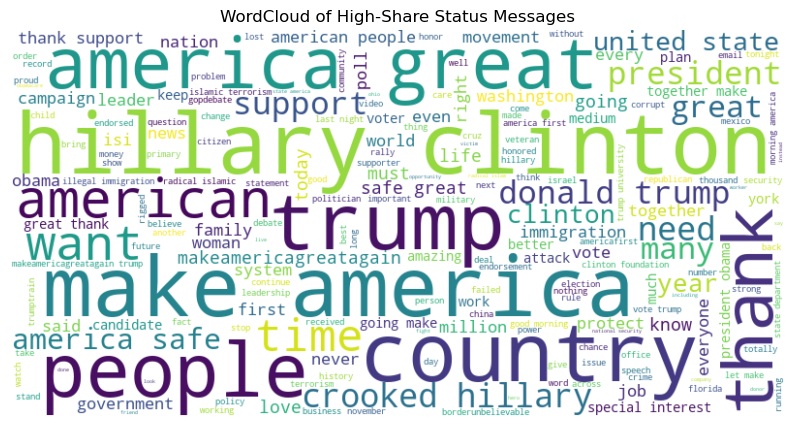

In [73]:
# Combine tokens into a single list of strings for WordCloud
# Iterate through each sublist in tokens1 and extract each word into flat_tokens
# This flattens the list of lists into a single list of strings
flat_tokens = [word for sublist in tokens1 for word in sublist]
# Join the list of tokens into a single string with spaces in between each word
text_for_wordcloud = ' '.join(flat_tokens)

# Create a WordCloud object with specified width, height, and background color
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_for_wordcloud)

# Plot the WordCloud
# Set up the figure size
plt.figure(figsize=(10, 6))
# Display the WordCloud image with bilinear interpolation
plt.imshow(wordcloud, interpolation='bilinear')
# Turn off the axis to remove the axis labels and ticks
plt.axis('off')
# Add a title to the plot
plt.title('WordCloud of High-Share Status Messages')
# Display the plot
plt.show()


## Finding the optimal number for topics with CoherenceModel

In [74]:
# Create a gensim Dictionary object called 'dictionary1' from the list of tokens 'tokens1'.
dictionary1 = gensim.corpora.Dictionary(tokens1)

# Filter the dictionary to remove tokens that appear in fewer than 5 documents,
# tokens that appear in more than 10% of the documents, and keep only the top 100,000 tokens.
dictionary1.filter_extremes(no_below=5, no_above=0.1, keep_n=100000)

# Convert each document's tokens into bag-of-words representation using the filtered dictionary.
# 'bag_word1' is a list of tuples where each tuple represents a document and contains
# (word_id, word_frequency) pairs according to the dictionary.
bag_word1 = [dictionary1.doc2bow(token) for token in tokens1]


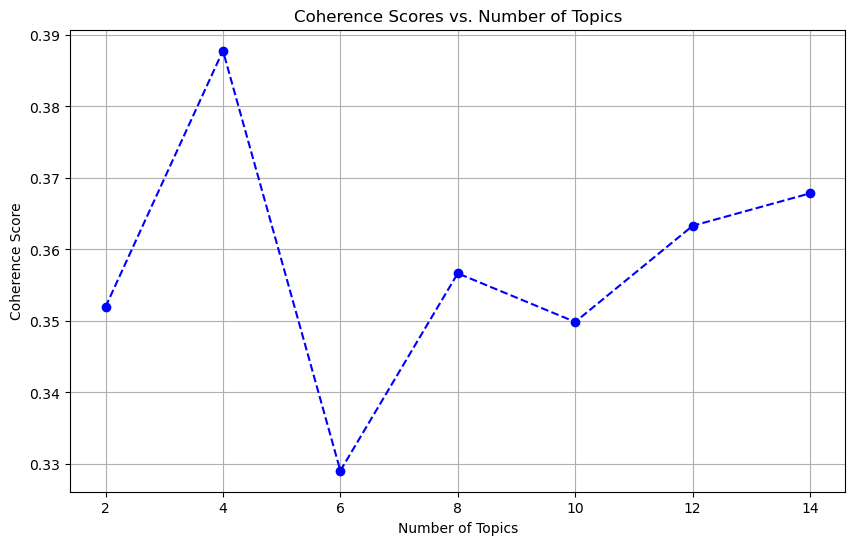

In [28]:
# Initializing an empty list to store coherence scores
coherence_scores1 = []
# Looping through different numbers of topics to evaluate their coherence scores
for num_topics in range(2, 16, 2): 
    # Building an LDA model with specified parameters
    lda_model1 = gensim.models.LdaMulticore(corpus=bag_word1, num_topics=num_topics, id2word=dictionary1, passes=10, workers=2)
    # Calculating coherence score for the LDA model
    coherence_model1 = CoherenceModel(model=lda_model1, texts=tokens1, dictionary=dictionary1, coherence='c_v')
    coherence_score1 = coherence_model1.get_coherence()
    # Appending the coherence score to the list
    coherence_scores1.append(coherence_score1)

# Plotting the elbow curve to visualize coherence scores vs. number of topics
plt.figure(figsize=(10, 6))
plt.plot(range(2, 16, 2), coherence_scores1, marker='o', linestyle='--', color='b')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Scores vs. Number of Topics")
plt.xticks(range(2, 16, 2)) # Setting x-axis ticks
plt.grid(True)
plt.show()


## <span style="color:brown;">Method 1: Retrieve topics with having a high number of shares using LdaMulticore.</span>

In [75]:
# Creating an instance of the LdaMulticore model for topic modeling
# Parameters:
# - corpus: The bag of words representation of the documents to be modeled
# - num_topics: The number of topics to be identified in the corpus
# - id2word: A mapping from word IDs to words in the dictionary
# - passes: The number of passes through the corpus during training
# - workers: The number of CPU cores to use for parallelization during training
lda_ml1 = gensim.models.LdaMulticore(corpus=bag_word1, num_topics=4, id2word = dictionary1, passes = 50, workers=2)

In [76]:
# Get the topics and their top keywords from the LDA (Latent Dirichlet Allocation) model lda_ml1
topics1 = lda_ml1.print_topics(num_words=10)

# Display the topics and their top keywords1
for topic in topics1:
    # Unpack the topic index and its corresponding keywords
    topic_index, topic_keywords = topic
    # Extract the keywords and format them into a list
    keyword_list = ', '.join([word.split('*')[1].strip() for word in topic_keywords.split('+')])
    # Print the topic index along with its top keywords
    print(f'Topic {topic_index}: {keyword_list}')



Topic 0: "donald", "state", "illegal", "united", "wall", "border", "american", "proud", "governor", "time"
Topic 1: "crooked", "party", "campaign", "need", "special", "medium", "system", "interest", "strong", "politician"
Topic 2: "american", "want", "state", "going", "radical", "obama", "life", "know", "need", "first"
Topic 3: "poll", "safe", "together", "love", "going", "vote", "time", "movement", "let", "good"


## <span style="color:brown;">Method 2: Retrieve topics with having a high number of shares using LatentDirichletAllocation.</span>

In [77]:
# Combine tokens into a single string for analysis
text_for_analysis1 = [' '.join(token_list) for token_list in tokens1]

# Vectorize the text using CountVectorizer
vectorizer1 = CountVectorizer()
X1 = vectorizer1.fit_transform(text_for_analysis1)

# Apply Latent Dirichlet Allocation (LDA) for topic modeling
num_topics1 = 4
lda1 = LatentDirichletAllocation(n_components=num_topics1, random_state=42)
lda1.fit(X1)

# Display the top words for each topic
feature_names1 = vectorizer1.get_feature_names_out()
topics1 = {}
for topic_idx, topic in enumerate(lda1.components_):
    top_words_idx = topic.argsort()[:-10 - 1:-1]  # Extract indices of top 10 words for each topic
    top_words = [feature_names1[i] for i in top_words_idx]  # Get the actual words using the indices
    topics1[f'Topic {topic_idx + 1}'] = top_words

# Print the top words for each topic
for topic, top_words in topics1.items():
    print(f"{topic}: {', '.join(top_words)}")  # Display the top words for each topic


Topic 1: trump, great, america, thank, make, support, makeamericagreatagain, together, safe, poll
Topic 2: country, people, trump, time, special, politician, makeamericagreatagain, interest, great, woman
Topic 3: american, people, president, america, hillary, radical, country, need, obama, clinton
Topic 4: hillary, clinton, crooked, country, people, state, american, america, million, email


# Visualizing topics with having a high number of shares with pyLDAvi

In [78]:
# Import the pyLDAvis library and enable its functionality in Jupyter Notebook
pyLDAvis.enable_notebook()

# Visualize the Latent Dirichlet Allocation (LDA) model results
# Prepare the visualization by passing the trained LDA model (lda1), the document-term matrix (X1),
# and the vectorizer used for creating the document-term matrix (vectorizer1)
my_lda_vis1 = pyLDAvis.lda_model.prepare(lda1, X1, vectorizer1)
# Display the prepared visualization of the LDA model
my_lda_vis1

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.163143  0.050552       1        1  35.910222
3      0.101611  0.024662       2        1  26.936298
2      0.070657  0.063360       3        1  23.911409
1     -0.009124 -0.138574       4        1  13.242071, topic_info=          Term        Freq       Total Category  logprob  loglift
591    clinton  268.000000  268.000000  Default  30.0000  30.0000
1571   hillary  275.000000  275.000000  Default  29.0000  29.0000
3408     thank  196.000000  196.000000  Default  28.0000  28.0000
1468     great  290.000000  290.000000  Default  27.0000  27.0000
3526     trump  310.000000  310.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
1468     great   14.027183  290.479416   Topic4  -5.2769  -1.0088
138   american   11.455856  149.654075   Topic4  -5.4794  -0.5481
2040      many    9.087687   65.673977   Topic4  -5.7109   0.0440
2482      plan    8.200130   27.992772   Topic4  -5.8137   0.7940
135    america    9.734258  333.401597   Topic4  -5.6422  -1.5119

[300 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
8         4  0.641734   abortion
22        2  0.832311   accessed
48        1  0.870091      added
86        1  0.901873  afternoon
89        2  0.854897     agenda
...     ...       ...        ...
3807      4  0.121861       year
3812      1  0.688030       york
3812      2  0.172008       york
3812      3  0.057336       york
3812      4  0.114672       york

[508 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 2])

In [33]:
# Saving the pyLDAvi
pyLDAvis.save_html(my_lda_vis1, 'high_share_topics.html')

## <span style="color:orange;">QUESTION 6: What are the themes (topics or top words) that generated a lot of num_reactions?</span>

In [79]:
# Combine status messages with a high number of reactions
# Select rows where the sum of reactions (likes, loves, sads, angrys) is greater than the 75th percentile of the sum of reactions across all rows
high_react = data[data[['num_likes', 'num_loves', 'num_sads', 'num_angrys']].sum(axis=1) > data[['num_likes', 'num_loves', 'num_sads', 'num_angrys']].sum(axis=1).quantile(0.75)]['status_message']

# Tokenize and preprocess the text
# Drop any NaN values from the selected status messages and apply a preprocessing function (preprocess_and_tokenize) to tokenize and preprocess the text
tokens2 = high_react.dropna().apply(preprocess_and_tokenize)


## World Cloud of topics with having a high number of reactions.

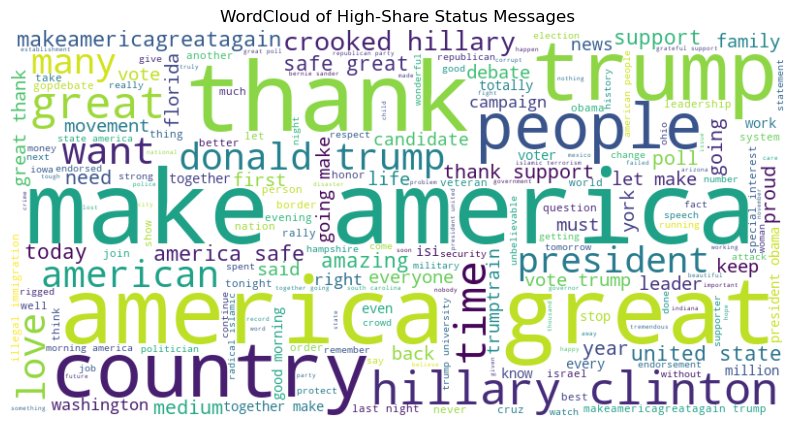

In [80]:
# Combine tokens into a single list of strings for WordCloud
# Iterate through each sublist in tokens2 and append each word to flat_tokens2
flat_tokens2 = [word for sublist in tokens2 for word in sublist]

# Combine the words in flat_tokens2 into a single string separated by spaces
text_for_wordcloud2 = ' '.join(flat_tokens2)

# Create a WordCloud object with specified width, height, and background color,
# then generate the WordCloud based on the combined text
wordcloud2 = WordCloud(width=800, height=400, background_color='white').generate(text_for_wordcloud2)

# Plot the WordCloud
# Set the figure size, display the WordCloud image with bilinear interpolation,
# hide the axes, set the title, and show the plot
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of High-Share Status Messages')
plt.show()

## Finding the optimal number for topics with CoherenceModel

In [81]:
# Creating a dictionary from a list of tokens (presumably representing documents)
# tokens2: List of tokenized documents
dictionary2 = gensim.corpora.Dictionary(tokens2)
# Filtering the dictionary to remove terms that are too rare or too common
# no_below: Minimum frequency count for a term to be included in the dictionary
# no_above: Maximum ratio of documents a term can appear in to be included in the dictionary
# keep_n: Maximum number of terms to keep after filtering
dictionary2.filter_extremes(no_below=15, no_above=0.1, keep_n=100000)
# Converting the tokenized documents into bag-of-words format using the filtered dictionary
# bag_word2: List of bag-of-words representations of the tokenized documents
bag_word2 = [dictionary2.doc2bow(token) for token in tokens2]

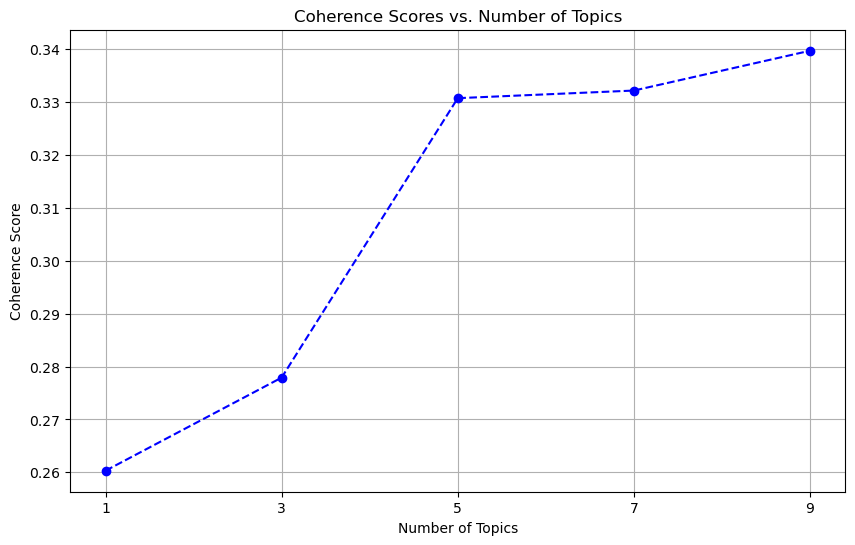

In [47]:
# Initializing an empty list to store coherence scores
coherence_scores2 = []
# Looping through different numbers of topics
for num_topics in range(1, 10, 2): 
    # Creating an LDA model with specified parameters
    lda_model2 = gensim.models.LdaMulticore(corpus=bag_word2, num_topics=num_topics, id2word=dictionary2, passes=10, workers=2)
    # Calculating coherence score for the LDA model
    coherence_model2 = CoherenceModel(model=lda_model2, texts=tokens2, dictionary=dictionary2, coherence='c_v')
    coherence_score2 = coherence_model2.get_coherence()
    # Appending the coherence score to the list
    coherence_scores2.append(coherence_score2)

# Plotting the elbow curve to visualize coherence scores for different numbers of topics
plt.figure(figsize=(10, 6))
plt.plot(range(1, 10, 2), coherence_scores2, marker='o', linestyle='--', color='b')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Scores vs. Number of Topics") 
plt.xticks(range(1, 10, 2))  # Setting x-axis ticks to match the range of topics
plt.grid(True)  # Adding grid lines for better readability
plt.show()  # Displaying the plot


## <span style="color:brown;">Method 1: Retrieve topics with having a high number of reactions using LdaMulticore.</span>

In [82]:
# Create an LDA (Latent Dirichlet Allocation) model using Gensim's LdaMulticore method.
# Parameters:
# - corpus: the bag-of-words representation of the documents
# - num_topics: the number of topics to extract from the corpus
# - id2word: mapping of word IDs to words (dictionary)
# - passes: number of passes through the corpus during training
# - workers: number of CPU cores to use for parallelization
lda_ml2 = gensim.models.LdaMulticore(corpus=bag_word2, num_topics=5, id2word = dictionary2, passes = 50, workers=2)
# Extract the topics and their top keywords from the trained LDA model.
topics2 = lda_ml2.print_topics(num_words=10)

# Display the topics and their top keywords.
for topic in topics2:
    # Unpack the topic index and keywords from the tuple.
    topic_index, topic_keywords = topic
    # Extract the top keywords from the topic_keywords string and join them into a list.
    keyword_list = ', '.join([word.split('*')[1].strip() for word in topic_keywords.split('+')])
    # Print the topic index and its top keywords.
    print(f'Topic {topic_index}: {keyword_list}')

Topic 0: "going", "back", "republican", "illegal", "special", "candidate", "immigration", "safe", "campaign", "party"
Topic 1: "poll", "crooked", "let", "good", "vote", "medium", "florida", "morning", "amazing", "never"
Topic 2: "makeamericagreatagain", "last", "time", "night", "debate", "family", "donald", "governor", "endorsement", "much"
Topic 3: "state", "love", "united", "together", "proud", "york", "everyone", "today", "carolina", "amazing"
Topic 4: "american", "obama", "need", "life", "every", "even", "radical", "attack", "thing", "leadership"


## <span style="color:brown;">Method 2: Retrieve topics with having a high number of reactions using LatentDirichletAllocation.</span>

In [83]:
# Combine tokens into a single string for analysis
text_for_analysis2 = [' '.join(token_list) for token_list in tokens2]

# Vectorize the text using CountVectorizer
vectorizer2 = CountVectorizer()
X2 = vectorizer2.fit_transform(text_for_analysis2)

# Apply Latent Dirichlet Allocation (LDA) for topic modeling
num_topics2 = 5
lda2 = LatentDirichletAllocation(n_components=num_topics2, random_state=42)
lda2.fit(X2)

# Display the top words for each topic
feature_names2 = vectorizer2.get_feature_names_out()
topics2 = {}
for topic_idx, topic in enumerate(lda2.components_):
    top_words_idx = topic.argsort()[:-10 - 1:-1]
    top_words = [feature_names2[i] for i in top_words_idx]
    topics2[f'Topic {topic_idx + 1}'] = top_words

# Print the top words for each topic
for topic, top_words in topics2.items():
    print(f"{topic}: {', '.join(top_words)}")

Topic 1: trump, president, israel, university, people, obama, work, makeamericagreatagain, american, state
Topic 2: hillary, clinton, crooked, great, people, time, rigged, many, america, american
Topic 3: hillary, clinton, people, country, want, president, american, need, trump, going
Topic 4: trump, makeamericagreatagain, president, people, country, life, interest, special, american, great
Topic 5: great, america, thank, make, trump, support, love, together, safe, going


# Visualizing topics with having a high number of reactions with pyLDAvi

In [84]:
# Enable the visualization of the LDA model within a Jupyter notebook environment
pyLDAvis.enable_notebook()

# Prepare the data for visualization using the LDA model
# lda2: the trained LDA model
# X2: the document-term matrix used for training the LDA model
# vectorizer2: the vectorizer used to transform text data into the document-term matrix
my_lda_vis2 = pyLDAvis.lda_model.prepare(lda2, X2, vectorizer2)
# Visualize the LDA model
my_lda_vis2

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.225593  0.027365       1        1  32.368785
2      0.093642  0.044750       2        1  22.529870
1      0.068896  0.095688       3        1  17.246601
3      0.037235 -0.024264       4        1  14.080474
0      0.025820 -0.143539       5        1  13.774270, topic_info=         Term        Freq       Total Category  logprob  loglift
2688    thank  255.000000  255.000000  Default  30.0000  30.0000
1227  hillary  144.000000  144.000000  Default  29.0000  29.0000
98    america  300.000000  300.000000  Default  28.0000  28.0000
1137    great  335.000000  335.000000  Default  27.0000  27.0000
1595     make  217.000000  217.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
1607     many    6.541103   52.242225   Topic5  -5.7678  -0.0954
2718     time    6.743869   80.120421   Topic5  -5.7373  -0.4925
2688    thank    7.189610  255.361170   Topic5  -5.6733  -1.5877
1595     make    7.026590  217.485838   Topic5  -5.6962  -1.4501
773    donald    6.011953   58.441955   Topic5  -5.8521  -0.2919

[345 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
4         4  0.937405        abortion
27        4  0.937405     acknowledge
34        1  0.830598           added
41        2  0.124034  administration
41        5  0.868239  administration
...     ...       ...             ...
3010      4  0.105839            year
3010      5  0.132299            year
3013      1  0.880940            york
3013      3  0.056835            york
3013      5  0.056835            york

[617 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 2, 4, 1])

In [51]:
# Saving the pyLDAvi
pyLDAvis.save_html(my_lda_vis2, 'high_react_topics.html')